# Decision Analysis - Project 2

### UTA Method

---
**Team members:**

- Sofya Aksenyuk, 150284
- Uladzimir Ivashka, 150281

---

## Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from pulp import *  
import pulp

## Dataset

In [2]:
df = pd.read_csv('Dataset.csv')

In [3]:
df = df.set_index('Alternative')

In [4]:
df

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
Alternative,,,,
a1,98,8,140,400
a2,58,0,123,800
a3,66,5,128,1000
a4,74,3,106,600
a5,80,7,147,200
a6,82,10,118,600
a7,58,1,109,200
a8,73,12,132,800
a9,92,9,121,500


In [5]:
df.describe()

,g1 (gain),g2 (gain),g3 (gain),g4 (cost)
count,12.000000,12.000000,12.000000,12.000000
mean,77.416667,5.750000,123.333333,575.000000
std,14.177180,3.646293,15.552453,259.807621
min,58.000000,0.000000,105.000000,200.000000
25%,66.750000,3.000000,108.250000,375.000000
50%,77.000000,5.500000,122.000000,600.000000
75%,84.500000,8.250000,134.000000,800.000000
max,100.000000,12.000000,147.000000,1000.000000


---

There are **twelve alternatives**, each of them representing a house to buy, e.g.:

- a1 - one-store countryside house of 140 $m^2$ area with the garage of 98 $m^2$ and garden of 8 hectares. All for the cost of 400'000 USD.

There are **four criterias** describing a place, taken from a local estate agency website:

- g1 - garage area (in $m^2$) 
- g2 - garden size (in hectares)
- g3 - living area (in $m^2$)
- g4 - cost (in thousands USD)

where, we would like to maximize first three criterias for as less price as possible.

Decision Maker stated their preferences on the importance of each criteria. Therefore, the **weights** are different for each of them. Each of them is relevant, but garden area (g2) is of least priority. The weights are as follows:

- [3, 1, 4, 6]

for criterias [g1, g2, g3, g4] respectively.

Ranges of each criteria values:

- g1: 58-100 ($m^2$) (gain type)
- g2: 0-10 (hectares) (gain type)
- g3: 105-147 ($m^2$) (gain type)
- g4: 200-1000 (thousands USD) (cost type)

where, all of them are continious.

In [6]:
def get_addval_matrix(df, value_functions, weights):
    matrix = pd.DataFrame(index=df.index)
    
    matrix['u1'] = df['g1 (gain)'].apply(value_functions[0])
    matrix['u2'] = df['g2 (gain)'].apply(value_functions[1])
    matrix['u3'] = df['g3 (gain)'].apply(value_functions[2])
    matrix['u4'] = df['g4 (cost)'].apply(value_functions[3])
    matrix['U'] = np.sum(matrix * weights, axis=1)
    
    return matrix

In [7]:
g1_value_func = lambda x: np.where(x <= 79, 0.038 * x - 2.2, 0.009 * x + 0.047)
g2_value_func = lambda x: np.where(x <= 10, 0.05 * x, 0.25 * x - 2)
g3_value_func = lambda x: x / 42 - 2.5
g4_value_func = lambda x: -x / 800 + 1.25

value_functions = [g1_value_func, g2_value_func, g3_value_func, g4_value_func]
weights = np.array([3, 1, 4, 6])

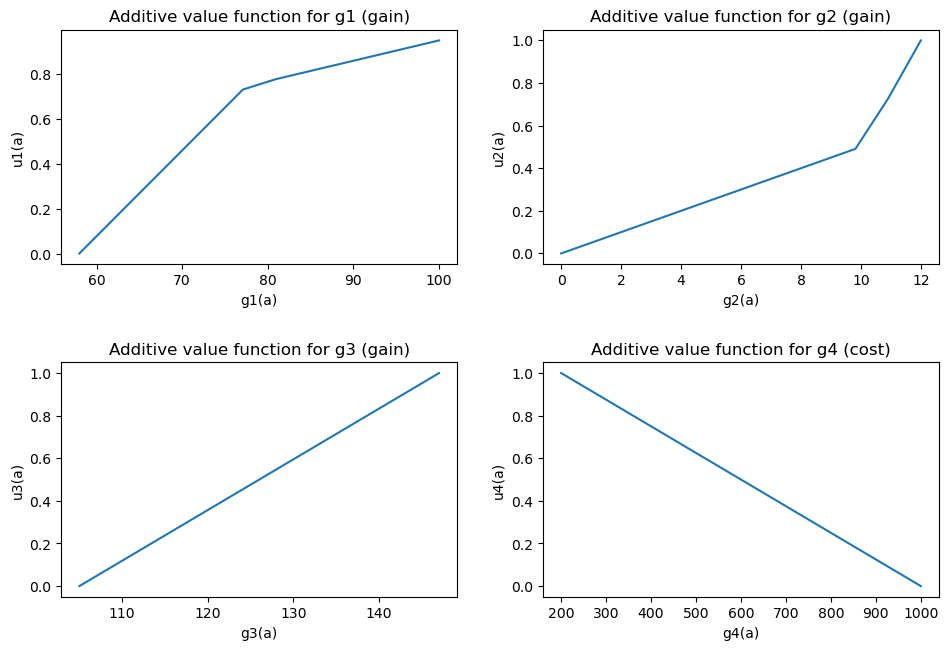

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.ravel()

for i, (col, val_func) in enumerate(zip(df.columns, value_functions)):
    x = np.linspace(min(df[col]), max(df[col]), len(df))
    ax[i].plot(x, val_func(x))
    ax[i].set_title(f'Additive value function for {col}')
    ax[i].set_ylabel(f'u{i+1}(a)')
    ax[i].set_xlabel(f'g{i+1}(a)')
fig.tight_layout(pad=2.5)

In [9]:
addval_matrix = get_addval_matrix(df, value_functions, weights)
display(addval_matrix)

,u1,u2,u3,u4,U
Alternative,,,,,
a1,0.929,0.40,0.833333,0.750,11.020333
a2,0.004,0.00,0.428571,0.250,3.226286
a3,0.308,0.25,0.547619,0.000,3.364476
a4,0.612,0.15,0.023810,0.500,5.081238
a5,0.767,0.35,1.000000,1.000,12.651000
a6,0.785,0.50,0.309524,0.500,7.093095
a7,0.004,0.05,0.095238,1.000,6.442952
a8,0.574,1.00,0.642857,0.250,6.793429
a9,0.875,0.45,0.380952,0.625,8.348810


## LP Model

---
### Apriori

Pairwise ranking comparison:

- a8 is preferred to a7 
- a5 is preferred to a1 
- a7 is preferred to a4 
- a3 is preferred to a2
- a1 is preferred to a6
- a4 is preferred to a2
- a9 is preferred to a7
- a10 is preferred to a1
- a12 is preferred to a11
- a5 is preferred to a6

Inconsistency added to LP Model:

- a12 is preferred to a11, when it is actually the opposite

---

In [10]:
model_inc = LpProblem(name="house-problem-with-inconsistency", sense=LpMinimize)

v_a1_a6 = LpVariable(name="v_a1_a6", cat=LpBinary)
v_a4_a2 = LpVariable(name="v_a4_a2", cat=LpBinary)
v_a9_a7 = LpVariable(name="v_a9_a7", cat=LpBinary)
v_a10_a1 = LpVariable(name="v_a10_a1", cat=LpBinary)
v_a11_a12 = LpVariable(name="v_a11_a12", cat=LpBinary)
v_a5_a6 = LpVariable(name="v_a5_a6", cat=LpBinary)
v_a8_a7 = LpVariable(name="v_a8_a7", cat=LpBinary)
v_a5_a1 = LpVariable(name="v_a5_a1", cat=LpBinary)
v_a7_a4 = LpVariable(name="v_a7_a4", cat=LpBinary)
v_a3_a2 = LpVariable(name="v_a3_a2", cat=LpBinary)

variables = [v_a1_a6, v_a4_a2, v_a9_a7, v_a10_a1, v_a11_a12, v_a5_a6]

model_inc += (addval_matrix.loc['a6']['U'] - v_a1_a6 <= addval_matrix.loc['a1']['U'], "#1 constraint")
model_inc += (addval_matrix.loc['a2']['U'] - v_a4_a2 <= addval_matrix.loc['a4']['U'], "#2 constraint")
model_inc += (addval_matrix.loc['a7']['U'] - v_a9_a7 <= addval_matrix.loc['a9']['U'], "#3 constraint")
model_inc += (addval_matrix.loc['a1']['U'] - v_a10_a1 <= addval_matrix.loc['a10']['U'], "#4 constraint")
model_inc += (addval_matrix.loc['a11']['U'] - v_a11_a12 <= addval_matrix.loc['a12']['U'], "#6 constraint")  ## inconsistency
model_inc += (addval_matrix.loc['a6']['U'] - v_a5_a6 <= addval_matrix.loc['a5']['U'], "#7 constraint")
model_inc += (addval_matrix.loc['a7']['U'] - v_a8_a7 <= addval_matrix.loc['a8']['U'], "#8 constraint")
model_inc += (addval_matrix.loc['a1']['U'] - v_a5_a1 <= addval_matrix.loc['a5']['U'], "#9 constraint")
model_inc += (addval_matrix.loc['a4']['U'] - v_a7_a4 <= addval_matrix.loc['a7']['U'], "#10 constraint")
model_inc += (addval_matrix.loc['a2']['U'] - v_a3_a2 <= addval_matrix.loc['a3']['U'], "#11 constraint")

V = v_a1_a6 + v_a4_a2 + v_a9_a7 + v_a10_a1 + v_a11_a12 + v_a5_a6
model_inc += V

model_inc

house-problem-with-inconsistency:
MINIMIZE
1*v_a10_a1 + 1*v_a11_a12 + 1*v_a1_a6 + 1*v_a4_a2 + 1*v_a5_a6 + 1*v_a9_a7 + 0
SUBJECT TO
#1_constraint: - v_a1_a6 <= 3.92723809524

#2_constraint: - v_a4_a2 <= 1.85495238095

#3_constraint: - v_a9_a7 <= 1.90585714286

#4_constraint: - v_a10_a1 <= 1.27542857143

#6_constraint: - v_a11_a12 <= -1.94

#7_constraint: - v_a5_a6 <= 5.5579047619

#8_constraint: - v_a8_a7 <= 0.350476190476

#9_constraint: - v_a5_a1 <= 1.63066666667

#10_constraint: - v_a7_a4 <= 1.36171428571

#11_constraint: - v_a3_a2 <= 0.13819047619

VARIABLES
0 <= v_a10_a1 <= 1 Integer
0 <= v_a11_a12 <= 1 Integer
0 <= v_a1_a6 <= 1 Integer
0 <= v_a3_a2 <= 1 Integer
0 <= v_a4_a2 <= 1 Integer
0 <= v_a5_a1 <= 1 Integer
0 <= v_a5_a6 <= 1 Integer
0 <= v_a7_a4 <= 1 Integer
0 <= v_a8_a7 <= 1 Integer
0 <= v_a9_a7 <= 1 Integer

In [11]:
print('--------Model with inconsistency--------')
status = model_inc.solve(solver = pulp.CPLEX_PY())
print(f"status: {model_inc.status}, {LpStatus[model_inc.status]}")
print(f"objective: {model_inc.objective.value()}")
for var in variables:
    print(var.name, pulp.value(var))

--------Model with inconsistency--------
Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Bound infeasibility column 'v_a11_a12'.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)


CPLEX Error  1217: No solution exists.


Cplex status= 103
status: -1, Infeasible
objective: None
v_a1_a6 None
v_a4_a2 None
v_a9_a7 None
v_a10_a1 None
v_a11_a12 None
v_a5_a6 None


---
The detected inconsistent constraint can be found as `Bound infeasibility column` in the CPLEX-solver output above. As it can be seen, the inconsistency was detected correctly, which also resulted in the objective function as well as variable values being equal to _None_.

---

In [12]:
model_no = LpProblem(name="house-problem-no-inconsistency", sense=LpMinimize)

model_no += (addval_matrix.loc['a6']['U'] - v_a1_a6 <= addval_matrix.loc['a1']['U'], "#1 constraint")
model_no += (addval_matrix.loc['a2']['U'] - v_a4_a2 <= addval_matrix.loc['a4']['U'], "#2 constraint")
model_no += (addval_matrix.loc['a7']['U'] - v_a9_a7 <= addval_matrix.loc['a9']['U'], "#3 constraint")
model_no += (addval_matrix.loc['a1']['U'] - v_a10_a1 <= addval_matrix.loc['a10']['U'], "#4 constraint")

## inconsistency removed
model_no += (addval_matrix.loc['a12']['U'] - v_a11_a12 <= addval_matrix.loc['a11']['U'], "#6 constraint") 

model_no += (addval_matrix.loc['a6']['U'] - v_a5_a6 <= addval_matrix.loc['a5']['U'], "#7 constraint")
model_no += (addval_matrix.loc['a7']['U'] - v_a8_a7 <= addval_matrix.loc['a8']['U'], "#8 constraint")
model_no += (addval_matrix.loc['a1']['U'] - v_a5_a1 <= addval_matrix.loc['a5']['U'], "#9 constraint")
model_no += (addval_matrix.loc['a4']['U'] - v_a7_a4 <= addval_matrix.loc['a7']['U'], "#10 constraint")
model_no += (addval_matrix.loc['a2']['U'] - v_a3_a2 <= addval_matrix.loc['a3']['U'], "#11 constraint")

V_no = v_a1_a6 + v_a4_a2 + v_a9_a7 + v_a10_a1 + v_a11_a12 + v_a5_a6
model_no += V_no

In [13]:
print('--------Model without inconsistency--------')
status = model_no.solve(solver = pulp.CPLEX_PY())
print(f"status: {model_no.status}, {LpStatus[model_no.status]}")
print(f"objective: {model_no.objective.value()}")
for var in variables:
    print(var.name, pulp.value(var))

--------Model without inconsistency--------
Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Cplex status= 101
status: 1, Optimal
objective: 0.0
v_a1_a6 0.0
v_a4_a2 0.0
v_a9_a7 0.0
v_a10_a1 0.0
v_a11_a12 0.0
v_a5_a6 0.0


---
Once the inconsistent constraint is removed, the solver is able to fins the optimal solution (which is zero).

---

## Result Comparison

In [14]:
promethee2_rank = np.array(['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a3', 'a2', 'a12'])
promethee1_pos_rank = np.array(['a10', 'a5', 'a1', 'a9', 'a7', 'a6', 'a8', 'a3', 'a4', 'a2', 'a11', 'a12'])
promethee1_neg_rank = np.array(['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a2', 'a12', 'a3'])
uta_rank = np.array(addval_matrix['U'].sort_values(ascending=False).index)

print('Ranks of all methods:')
print(promethee2_rank, '<- PROMETHEE II')
print(uta_rank, '<- UTA')
print(promethee1_pos_rank, '<- PROMETHEE I Ф+')
print(promethee1_neg_rank, '<- PROMETHEE I Ф-')

Ranks of all methods:
['a10' 'a5' 'a1' 'a9' 'a6' 'a8' 'a7' 'a4' 'a11' 'a3' 'a2' 'a12'] <- PROMETHEE II
['a5' 'a10' 'a1' 'a9' 'a6' 'a8' 'a7' 'a4' 'a11' 'a3' 'a2' 'a12'] <- UTA
['a10' 'a5' 'a1' 'a9' 'a7' 'a6' 'a8' 'a3' 'a4' 'a2' 'a11' 'a12'] <- PROMETHEE I Ф+
['a10' 'a5' 'a1' 'a9' 'a6' 'a8' 'a7' 'a4' 'a11' 'a2' 'a12' 'a3'] <- PROMETHEE I Ф-


---
As it can be seen, the best and worst alternatives found by different methods are nearly the same, except a5 and a10 alternatives "switching" first and second places.

---

In [15]:
d = 0.5 * sum(promethee2_rank != uta_rank)
m = len(uta_rank)
t = 1 - 4 * (d / (m * (m - 1)))

print(f'Kendall’s tau between Promethee II and UTA methods: {t}')

Kendall’s tau between Promethee II and UTA methods: 0.9696969696969697


---
Kendall's tau of around 0.97 constitutes to the fact that there's almost perfect agreement between the two rankings.

---

It was noticed that weights distribution plays a big role in the results. In case of UTA, defining weights was essential to obtain the correct, consistent with the Apriori DM preference information results. In contrary, when no weights are assigned, the ranking is rather general, taking no DM's preferences into account.